In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight


In [2]:
# https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/code
# https://www.kaggle.com/datasets/danieleligato/ditsclassificaton


## Read data from give dataset 

In [3]:
#  create dictionary for shape and class labels
shape_mapping = {'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}
# create dict for shape dataframe
shape_data = {'Img Path': [], 'Class': []}

# directory of the training images and the independent test images
directory = ('./trafficsigns_dataset/trafficsigns_dataset/')
test_directory = './test/'

# read Image Path with labels to dictionary  
for item in os.listdir(directory):
    item_name = os.fsdecode(item)
    
    # filter items that are not files
    if not (os.path.isdir((os.path.join(directory, item_name)))):
        continue
    
    # get the image path
    curr_path = os.path.join(directory, item_name)
    for sub_item in os.listdir(curr_path):
        type_name = os.fsdecode(sub_item)
        path = os.path.join(curr_path, sub_item)
        if not (os.path.isdir(path)):
            continue

        for img in os.listdir(path):
            temp = shape_data['Img Path']
            temp.append(os.path.join(path, img))
            shape_data['Img Path'] = temp


            temp = shape_data['Class']
            temp.append(shape_mapping[item_name])
            shape_data['Class'] = temp


shape_df = pd.DataFrame(data=shape_data)


In [4]:
# function to get the test images
def get_test_imgs(directory):
    shape_data = {'Img Path': [], 'Class': []}
    for item in os.listdir(directory):
        item_name = os.fsdecode(item)
        
        if not (os.path.isdir((os.path.join(directory, item_name)))):
            continue
        
        curr_path = os.path.join(directory, item_name)
        for sub_item in os.listdir(curr_path):
            type_name = os.fsdecode(sub_item)
            path = os.path.join(curr_path, sub_item)
            if not (os.path.isdir(path)):
                continue

            for img in os.listdir(path):
                temp = shape_data['Img Path']
                temp.append(os.path.join(path, img))
                shape_data['Img Path'] = temp
                    # Open the image file
                image = Image.open(os.path.join(path, img))

                # Resize the image to a desired size (e.g., 300x300)
                new_size = (28, 28)
                resized_image = image.resize(new_size)

                # Convert the image to grayscale
                grayscale_image = resized_image.convert("L")

                # Save or display the grayscale image
                grayscale_image.save(os.path.join(path, img))


                temp = shape_data['Class']
                temp.append(shape_mapping[item_name])
                shape_data['Class'] = temp


pd.DataFrame(get_test_imgs('./test'))

""


In [5]:
# Put the test images in a test dataframe
shape_test = get_test_imgs('./test')
test_df = pd.DataFrame(data=shape_test)
# Change the type of Class column to string
shape_df['Class'] = shape_df['Class'].astype('str')

<Axes: xlabel='Class', ylabel='count'>

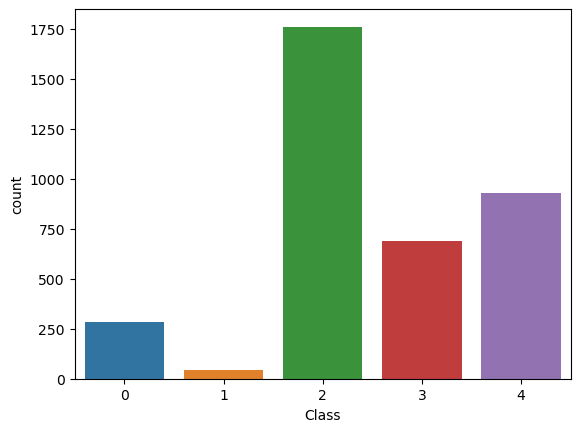

In [6]:
# Countplot for the dataset's labels
sns.countplot(data=shape_df, x='Class')

## Baseline model

In [7]:
# Build the baseline model
INPUT_DIM = (28,28,1)
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 5
def baseline_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=None),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=None),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=None),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=None),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    ])
    return model


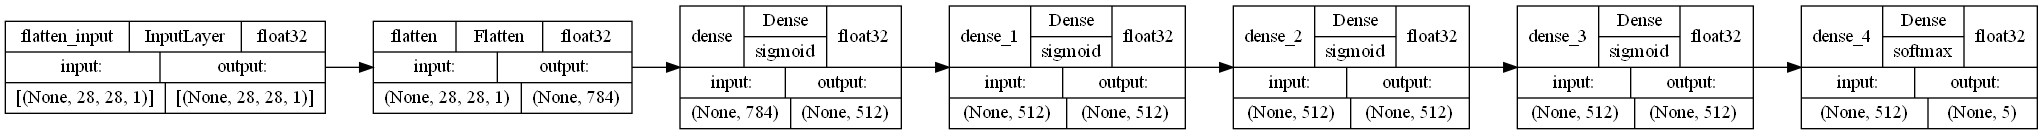

In [8]:
# Plot the structure of the baseline model
tf.keras.utils.plot_model(baseline_model(), show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True, rankdir='LR')

## CNN model

In [9]:
# Set up the CNN
reg_lambda = 0.002
model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    # Convolutional layers
    tf.keras.layers.Conv2D(10, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(10, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(10, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [10]:
model = model_leNet

Visualize the neural networks

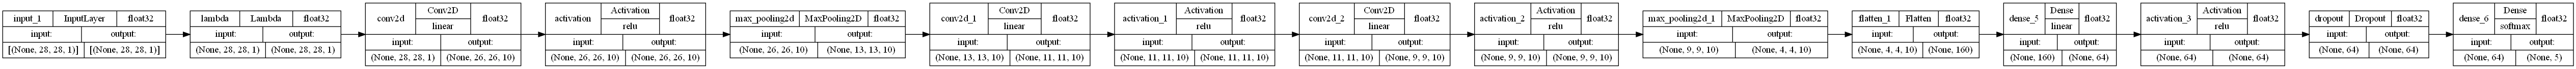

In [11]:
# Plot the CNN structure
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True, rankdir='LR')

### Functions for results evaluation

In [12]:
# Define the plot function for model evaluation
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [13]:
# Define manual calculation for F1 score

# Calculate recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
# Calculate precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
# Calculate F1 score 
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Data splitting

In [14]:
# Data splitting
train_data, test_data = train_test_split(shape_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)
train_data['Class'] = train_data['Class'].astype('str')
val_data['Class'] = val_data['Class'].astype('str')

## Train the model

In [15]:
# Create image data generators for training the model
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 20

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Img Path",
        y_col="Class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Img Path",
        y_col="Class",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2220 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


### Initialise class weights for models

In [16]:
# Compute the class weight to fight class imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                  classes = np.unique((train_data['Class'])), 
                                  y=train_data['Class'])
cls_wt = dict()
for i in range(len((weights))):
    cls_wt[i] = weights[i]

## Compile and evaluate model based on visualisations

In [17]:
# Compile the model
model.compile(optimizer=tf.optimizers.RMSprop(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[f1_m, "accuracy"],
              )

Epoch 1/27
111/111 [==============================] - 3s 15ms/step - loss: 1.6078 - f1_m: 0.0000e+00 - accuracy: 0.3905 - val_loss: 1.3464 - val_f1_m: 0.0000e+00 - val_accuracy: 0.7000
Epoch 2/27
111/111 [==============================] - 1s 13ms/step - loss: 1.3080 - f1_m: 0.1814 - accuracy: 0.5293 - val_loss: 0.9668 - val_f1_m: 0.4775 - val_accuracy: 0.6811
Epoch 3/27
111/111 [==============================] - 1s 13ms/step - loss: 0.8900 - f1_m: 0.4917 - accuracy: 0.6180 - val_loss: 0.7078 - val_f1_m: 0.6878 - val_accuracy: 0.8054
Epoch 4/27
111/111 [==============================] - 1s 12ms/step - loss: 0.6735 - f1_m: 0.6709 - accuracy: 0.7306 - val_loss: 0.5467 - val_f1_m: 0.8254 - val_accuracy: 0.8568
Epoch 5/27
111/111 [==============================] - 1s 13ms/step - loss: 0.5336 - f1_m: 0.7589 - accuracy: 0.8045 - val_loss: 0.4310 - val_f1_m: 0.8697 - val_accuracy: 0.8784
Epoch 6/27
111/111 [==============================] - 1s 13ms/step - loss: 0.4769 - f1_m: 0.8178 - accuracy

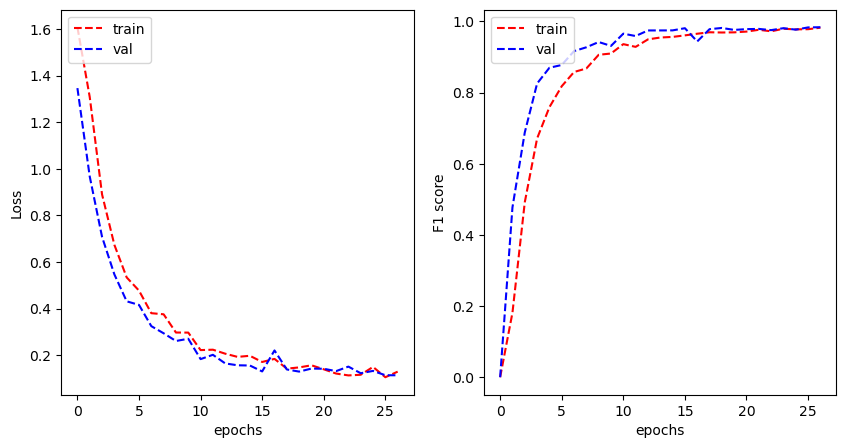

In [18]:
# Fit and plot the model performance
history = model.fit(train_generator, validation_data = validation_generator, epochs=27, verbose=1, class_weight=cls_wt)
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['f1_m'], history.history['val_f1_m'], 
                    metric_name='F1 score')

## Test on independent test data

In [19]:
# Read independent test data
shape_data = {'Img Path': [], 'Class': []}

type_mapping = {'rightofway': 0, 'stop': 1, 'bicycle': 2, 'limitedtraffic': 3, 'noentry':4, 'noparking': 5, 'roundabout': 6, 'speed': 7, 'trafficdirective': 8, 'traveldirection': 9, 'continue': 10, 'crossing': 11, 'laneend': 12, 'parking': 13, 'giveway': 14, 'warning': 15}

type_data = {'Img Path': [], 'Class': []}


directory = ('./test')
    
for item in os.listdir(directory):
    item_name = os.fsdecode(item)
    
    if not (os.path.isdir((os.path.join(directory, item_name)))):
        continue
    
    curr_path = os.path.join(directory, item_name)
    for sub_item in os.listdir(curr_path):
        type_name = os.fsdecode(sub_item)
        path = os.path.join(curr_path, sub_item)
        if not (os.path.isdir(path)):
            continue

        for img in os.listdir(path):
            temp = shape_data['Img Path']
            temp.append(os.path.join(path, img))
            shape_data['Img Path'] = temp
            type_data['Img Path'] = temp


            temp = shape_data['Class']
            temp.append(shape_mapping[item_name])
            shape_data['Class'] = temp

            temp = type_data['Class']
            temp.append(type_mapping[type_name])
            type_data['Class'] = temp
test_df = pd.DataFrame(data=shape_data)
test_df['Class'] = test_df['Class'].astype('str')

In [20]:
# Set up test data generator
test_df['Class'] = test_df['Class'].astype('str')
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='./',
        x_col="Img Path",
        y_col="Class",
        target_size=(28, 28),
        batch_size=1,
        class_mode='categorical')

Found 460 validated image filenames belonging to 5 classes.


In [21]:
# Evaluate model based on test data
model.evaluate(test_generator, batch_size=len(test_df['Class']))

460/460 [==============================] - 2s 4ms/step - loss: 0.7593 - f1_m: 0.7717 - accuracy: 0.8000


[0.7592747807502747, 0.7717390656471252, 0.800000011920929]

## Tuning regularization lambda value 

In [23]:
# Tune the regularization lambda
reg_lambdas = [i/1000 for i in range(2, 19, 4)]
arr = []
for i in range(len(reg_lambdas)):
    reg_lambda = reg_lambdas[i]
    model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(10, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(10, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(10, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
    ])
    model_leNet.compile(optimizer=tf.optimizers.RMSprop(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[f1_m, "accuracy"],
              )
    history = model_leNet.fit(train_generator, validation_data = validation_generator, epochs=27, verbose=1, class_weight=cls_wt)
    
    f1 = model_leNet.evaluate(test_generator, batch_size=len(test_df['Class']))[1]
    arr.append(f1)

Epoch 1/27
111/111 [==============================] - 2s 15ms/step - loss: 1.5787 - f1_m: 0.0051 - accuracy: 0.3009 - val_loss: 1.2975 - val_f1_m: 0.0727 - val_accuracy: 0.3919
Epoch 2/27
111/111 [==============================] - 1s 13ms/step - loss: 1.1214 - f1_m: 0.3187 - accuracy: 0.5189 - val_loss: 0.8534 - val_f1_m: 0.6101 - val_accuracy: 0.7973
Epoch 3/27
111/111 [==============================] - 1s 13ms/step - loss: 0.7714 - f1_m: 0.5956 - accuracy: 0.6959 - val_loss: 0.6501 - val_f1_m: 0.7610 - val_accuracy: 0.8405
Epoch 4/27
111/111 [==============================] - 1s 13ms/step - loss: 0.6279 - f1_m: 0.7140 - accuracy: 0.7775 - val_loss: 0.5552 - val_f1_m: 0.8123 - val_accuracy: 0.8649
Epoch 5/27
111/111 [==============================] - 1s 13ms/step - loss: 0.4645 - f1_m: 0.7991 - accuracy: 0.8338 - val_loss: 0.3549 - val_f1_m: 0.8927 - val_accuracy: 0.9122
Epoch 6/27
111/111 [==============================] - 1s 13ms/step - loss: 0.3574 - f1_m: 0.8501 - accuracy: 0.8653

111/111 [==============================] - 2s 14ms/step - loss: 0.2004 - f1_m: 0.9732 - accuracy: 0.9743 - val_loss: 0.1675 - val_f1_m: 0.9776 - val_accuracy: 0.9770
Epoch 20/27
111/111 [==============================] - 2s 14ms/step - loss: 0.1887 - f1_m: 0.9715 - accuracy: 0.9739 - val_loss: 0.1714 - val_f1_m: 0.9740 - val_accuracy: 0.9784
Epoch 21/27
111/111 [==============================] - 2s 15ms/step - loss: 0.1958 - f1_m: 0.9727 - accuracy: 0.9748 - val_loss: 0.1750 - val_f1_m: 0.9748 - val_accuracy: 0.9770
Epoch 22/27
111/111 [==============================] - 2s 15ms/step - loss: 0.1795 - f1_m: 0.9713 - accuracy: 0.9725 - val_loss: 0.1767 - val_f1_m: 0.9726 - val_accuracy: 0.9770
Epoch 23/27
111/111 [==============================] - 2s 14ms/step - loss: 0.1949 - f1_m: 0.9745 - accuracy: 0.9757 - val_loss: 0.1754 - val_f1_m: 0.9690 - val_accuracy: 0.9757
Epoch 24/27
111/111 [==============================] - 2s 14ms/step - loss: 0.1626 - f1_m: 0.9760 - accuracy: 0.9761 - val

111/111 [==============================] - 2s 16ms/step - loss: 0.4102 - f1_m: 0.9079 - accuracy: 0.9162 - val_loss: 0.3719 - val_f1_m: 0.9339 - val_accuracy: 0.9432
Epoch 11/27
111/111 [==============================] - 2s 17ms/step - loss: 0.3667 - f1_m: 0.9161 - accuracy: 0.9252 - val_loss: 0.3417 - val_f1_m: 0.9449 - val_accuracy: 0.9459
Epoch 12/27
111/111 [==============================] - 2s 14ms/step - loss: 0.4100 - f1_m: 0.9201 - accuracy: 0.9302 - val_loss: 0.3300 - val_f1_m: 0.9478 - val_accuracy: 0.9500
Epoch 13/27
111/111 [==============================] - 2s 14ms/step - loss: 0.3329 - f1_m: 0.9305 - accuracy: 0.9342 - val_loss: 0.3218 - val_f1_m: 0.9464 - val_accuracy: 0.9527
Epoch 14/27
111/111 [==============================] - 2s 13ms/step - loss: 0.3156 - f1_m: 0.9364 - accuracy: 0.9441 - val_loss: 0.3066 - val_f1_m: 0.9505 - val_accuracy: 0.9514
Epoch 15/27
111/111 [==============================] - 2s 13ms/step - loss: 0.3071 - f1_m: 0.9413 - accuracy: 0.9441 - val

460/460 [==============================] - 1s 3ms/step - loss: 0.6890 - f1_m: 0.7630 - accuracy: 0.7848


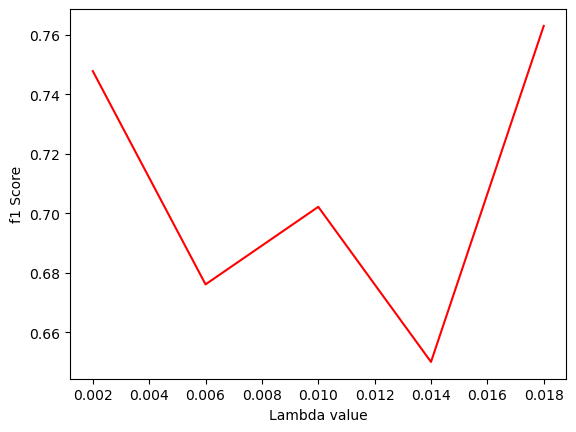

In [24]:
# Plot model performance on test data based on lambda values
plt.plot([lambda_para for lambda_para in reg_lambdas], 
         [tp for tp in arr], 'r-')

plt.xscale("linear")
plt.ylabel('f1 Score')
plt.xlabel('Lambda value')
plt.show()

In [25]:
# plot sample images
d_inv = {v: k for k, v in shape_mapping.items()}
plt.figure(figsize=(200,200))
batches = 0
for x,y in test_generator:
        # print(y)
        y_hat = model.predict(x, verbose=0)
        # if d_inv[np.argmax(y[0])] == d_inv[np.argmax(y_hat[0])]:
        #      continue
        batches = batches + 1
        x = np.squeeze(x)
        if batches <= 140:
            plt.subplot(7,20,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ), fontsize=45)
            
        else:
            break
        
        plt.axis('off')

In [26]:
len(test_generator)

460